In [4]:
import json
import os
import pickle
import sys

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler as rus

from scipy.ndimage import gaussian_filter1d as smooth

from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.utils import mkeqdata

from matplotlib import pyplot as plt
import seaborn as sns


In [36]:
_outPath = os.path.join(dirs['out']['dec'], 'c-ovr')

In [27]:
from scipy.io import loadmat
def read_neuron(path):
    cm = loadmat(os.path.join(os.path.dirname(path), 'cm.mat'))['cm']
    nstim = np.unique(cm).max()
    
    nsample = 900
    data = np.nan * np.zeros([nstim, 1, nsample])
    
    ua = loadmat(path)['ua']
    cm = cm[:ua.shape[0]]
    
    exit_flag = 0
    split_1, split_2 = [], []
    for istim in np.arange(1, 166):
        X = ua[(cm==istim).flatten(), :]
        nrep = X.shape[0]
        
        if nrep < 3:
            exit_flag = 1
            break

        first_half = X[:int(nrep/2), :]
        second_half = X[int(nrep/2):, :]

        split_1.append(first_half.mean(0))
        split_2.append(second_half.mean(0))
    
    return exit_flag, np.array(split_1), np.array(split_2)

In [38]:
def movavg(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
    for ibin in range(nbin):
        out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
    return out

In [37]:
selectivity = "fast"

itc_t, itc_v = [], []
for monkey in ['jenab', 'zebel']:
    info = pd.read_csv(f'/Data/{selectivity.capitalize()}/{monkey.capitalize()}/itcNeuralInfo.csv')
    for row in info.iterrows():
        ef, spl1, spl2 = read_neuron(row[1][0])
        if ef == 0:
            itc_t.append(spl1)
            itc_v.append(spl2)

itc_t = np.transpose(itc_t, [1, 0, 2])
itc_v = np.transpose(itc_v, [1, 0, 2])

pfc_t, pfc_v = [], []
for monkey in ['jenab', 'zebel']:
    info = pd.read_csv(f'/Data/{selectivity.capitalize()}/{monkey.capitalize()}/pfcNeuralInfo.csv')
    for row in info.iterrows():
        ef, spl1, spl2 = read_neuron(row[1][0])
        if ef == 0:
            pfc_t.append(spl1)
            pfc_v.append(spl2)

pfc_t = np.transpose(pfc_t, [1, 0, 2])
pfc_v = np.transpose(pfc_v, [1, 0, 2])

_data = {
    'itc_t': itc_t,
    'itc_v': itc_v,
    'pfc_t': pfc_t,
    'pfc_v': pfc_v
}

In [154]:
monkey = 'both'
nmb_rep = 30

outPath  = os.path.join(_outPath, f'{monkey.lower()}-{selectivity.lower()}')
os.makedirs(outPath, exist_ok=True)

cfn = {'itc': {'fac': [], 'bod': [], 'nat': [], 'art': []},
       'pfc': {'fac': [], 'bod': [], 'nat': [], 'art': []}}
dpr = {'itc': {'fac': [], 'bod': [], 'nat': [], 'art': []},
       'pfc': {'fac': [], 'bod': [], 'nat': [], 'art': []}}

for region in ['itc', 'pfc']:
    for category in ['fac', 'bod', 'nat', 'art']:
        
        for seed in (pbar := tqdm(range(nmb_rep))):
            with open("../utils/info.pkl", "rb") as handler:
                info = pickle.load(handler)
            info = info[:165]
            validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "A") | (info.sfr == "BI"))).to_numpy()
            data_t = movavg(_data[f'{region}_t'][validStimuliIndex], 25, 1)
            data_v = movavg(_data[f'{region}_v'][validStimuliIndex], 25, 1)
            info = info[validStimuliIndex].reset_index(drop=True)
        
            _cfn, _dpr = [], []
            pbar.set_description(monkey+"-"+selectivity+"-"+region+"-"+category)
            y = info[category].to_numpy()
            y0 = np.argwhere(y).flatten()
            y1 = np.argwhere(~y)
            np.random.seed(seed=seed)
            y1 = np.random.choice(y1.flatten(), size=y0.size, replace=False).flatten()
            y = np.concatenate([y0, y1])
            info = info.loc[y, :]
            data_t, data_v = data_t[y], data_v[y]
            y = info[category].to_numpy()
            
            for itime in np.arange(data_t.shape[2]):
                out = DCE(random_state=seed).fit(X_train=data_t[:, :, itime], y_train=y).score(data_v[:, :, itime], y_test=y)
                _cfn.append(out[0])
                _dpr.append(out[2])
            
            cfn[region][category].append(_cfn)
            dpr[region][category].append(_dpr)

for region in ['itc', 'pfc']:
    for category in ['fac', 'bod', 'nat', 'art']:
        dpr[region][category] = np.mean(dpr[region][category], 0)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [149]:
dpr2 = dpr.copy()

In [153]:
dpr2['itc']['fac'].shape

(30,)

In [150]:
for region in ['itc', 'pfc']:
    for category in ['fac', 'bod', 'nat', 'art']:
        dpr[region][category] = np.mean(dpr[region][category], 1)

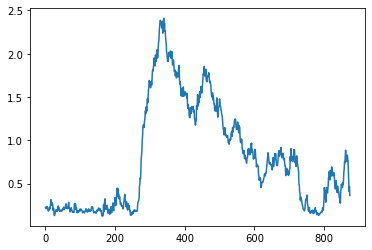

In [155]:
plt.plot(np.array((dpr['itc']['nat'])));

In [165]:
with open(os.path.join(dirs['out']['dec'], 'c-ovr-dpr.pickle'), 'wb') as handle:
    pickle.dump(dpr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(os.path.join(dirs['out']['dec'], 'c-ovr-cfn.pickle'), 'wb') as handle:
    pickle.dump(cfn, handle, protocol=pickle.HIGHEST_PROTOCOL)

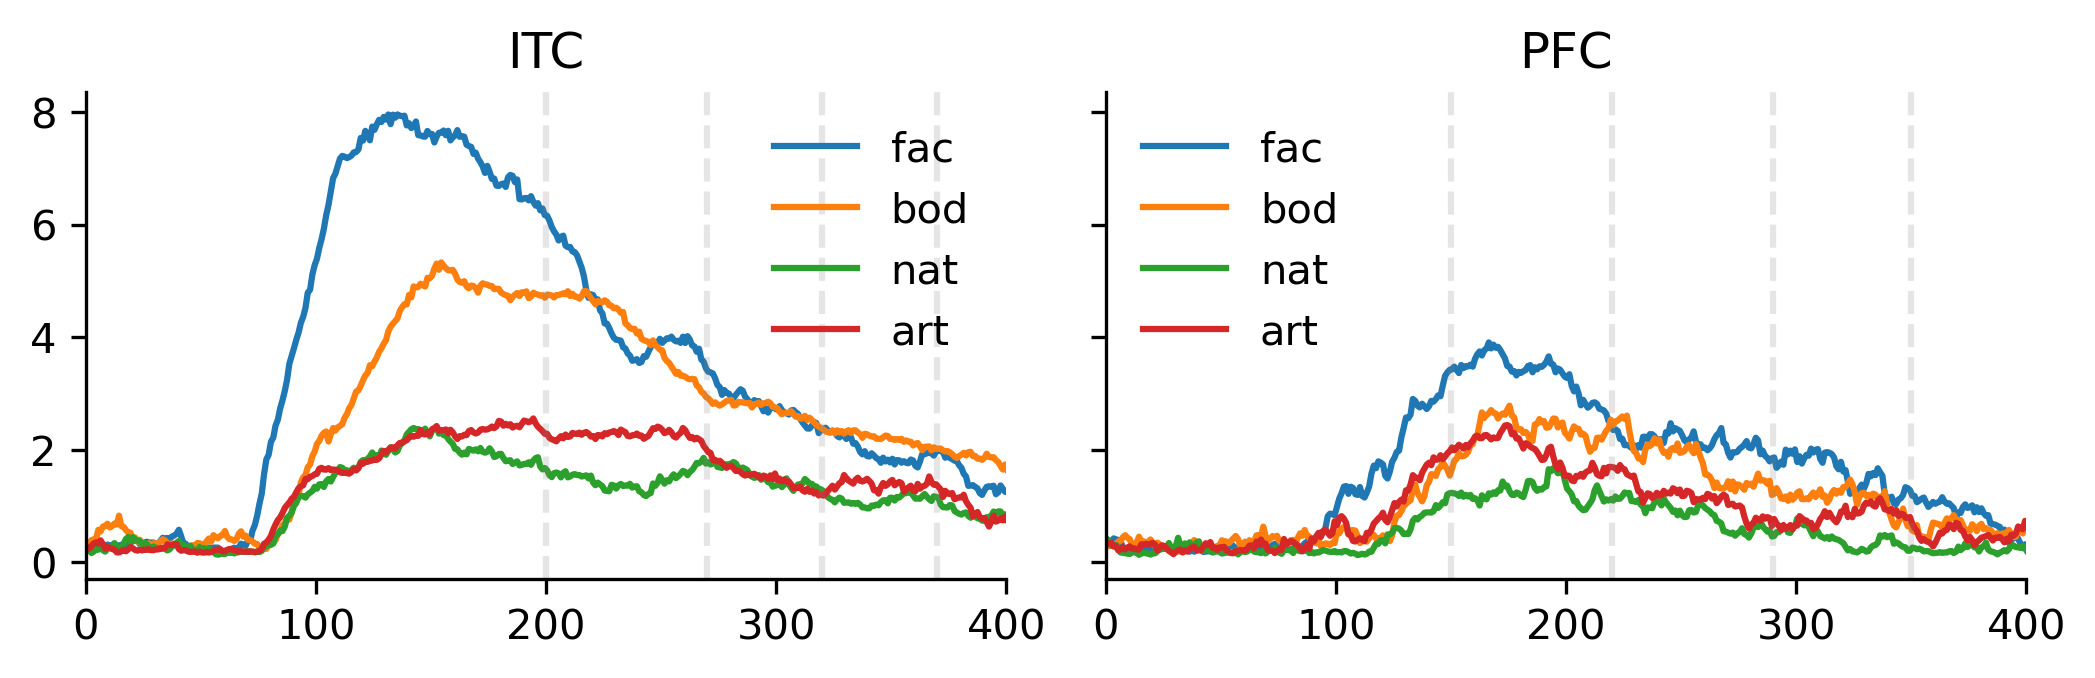

In [164]:
# cfn = np.array(cfn)
# acc = np.diagonal(cfn, axis1=2, axis2=3).sum(-1) / cfn.sum((2, 3))
cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm, 6 * cm), dpi=300, sharey=True)

for ax, region in zip(axs, dpr):
    d = dpr[region]
    for key in d.keys():
        ax.plot(np.arange(-200, 675) + 12.5, np.array(d[key]).T)
    ax.set_xlim(0, 400)
    ax.legend(d.keys(), frameon=False)
    ax.set_title(region.upper())

for v in [200, 270, 320, 370]:
    axs[0].axvline(v, ls='--', c='gray', alpha=.2, label='_nolegend_')
for v in [150, 220, 290, 350]:
    axs[1].axvline(v, ls='--', c='gray', alpha=.2, label='_nolegend_')

sns.despine()
fig.tight_layout()

In [119]:
cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm, 6 * cm), dpi=300)

for ax, region in zip(axs, dpr):
    d = dpr[region]
    for key in d.keys():
        ax.plot(np.arange(-200, 675) + 12.5, np.array(d[key]).T)
    ax.set_xlim(0, 400)
    ax.legend(d.keys(), frameon=False)
    ax.set_title(region.upper())
sns.despine()
fig.tight_layout()

'itc'

(0.0, 450.0)

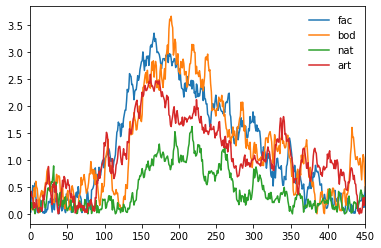

In [114]:
cfn = np.array(cfn)
acc = np.diagonal(cfn, axis1=2, axis2=3).sum(-1) / cfn.sum((2, 3))
for key in dpr.keys():
    plt.plot(np.arange(-200, 675) + 12.5, np.array(dpr[key]).T)
plt.legend(dpr.keys(), frameon=False);
plt.xlim(0, 450)